In [196]:
# BASE
import numpy as np
import pandas as pd
import math

# VISUALS
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as tck
import panel as pn
pn.extension("tabulator")
import plotly.express as px
import statsmodels.api as sm

# MODELING
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# MODEL TUNING
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV

# STATISTICS
from scipy.stats import t, ttest_1samp, ttest_ind, chisquare, cramervonmises_2samp, ks_2samp, mannwhitneyu, kruskal

import warnings
warnings.filterwarnings("ignore")

In [197]:
# Installing geopy for the Europe map
!pip install geopy

from geopy.geocoders import Nominatim

# Analysis of Wheat Production in Ireland (compared to Austria and Sweden)

## 1. Data Preparation and Visualization

### 1.1 Data Preparation

In [198]:
# From The Food and Agriculture Organization (FAO) data
# Crops and livestock products dataset 1960-2021: https://www.fao.org/faostat/en/#data/QCL
df_crops_all = pd.read_csv("FAOSTAT_data_eu_Crops and livestock products (1).csv")
# From World Bank data
# Population 1961-2021: https://data.worldbank.org/indicator/SP.POP.TOTL
df_population_all = pd.read_csv("WORLDBANK_data_Population.csv")

In [199]:
df_crops_all.sample(5)

,Domain Code,Domain,Area Code (M49),Area,Element Code,Element,Item Code (CPC),Item,Year Code,Year,Unit,Value,Flag,Flag Description
2273,QCL,Crops and livestock products,372,Ireland,5510,Production,111,Wheat,2015,2015,tonnes,696600.0,A,Official figure
3830,QCL,Crops and livestock products,724,Spain,5312,Area harvested,111,Wheat,1994,1994,ha,1969650.0,A,Official figure
2538,QCL,Crops and livestock products,428,Latvia,5510,Production,111,Wheat,2007,2007,tonnes,807300.0,A,Official figure
822,QCL,Crops and livestock products,203,Czechia,5312,Area harvested,111,Wheat,1993,1993,ha,780236.0,A,Official figure
3032,QCL,Crops and livestock products,528,Netherlands,5510,Production,111,Wheat,1983,1983,tonnes,1042914.0,A,Official figure


In [200]:
df_population_all.sample(5)

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
156,Middle income,MIC,"Population, total",SP.POP.TOTL,2.101463e+09,2.129016e+09,2.169685e+09,2.222461e+09,2.275510e+09,2.329439e+09,...,5.354645e+09,5.421202e+09,5.487659e+09,5.552696e+09,5.616265e+09,5.679375e+09,5.740016e+09,5.797828e+09,5.852404e+09,5.901324e+09
185,Panama,PAN,"Population, total",SP.POP.TOTL,1.126989e+06,1.160832e+06,1.196289e+06,1.233267e+06,1.271461e+06,1.310556e+06,...,3.754862e+06,3.821556e+06,3.888793e+06,3.957099e+06,4.026336e+06,4.096063e+06,4.165255e+06,4.232532e+06,4.294396e+06,4.351267e+06
82,Georgia,GEO,"Population, total",SP.POP.TOTL,3.645600e+06,3.703600e+06,3.760300e+06,3.816100e+06,3.870300e+06,3.921600e+06,...,3.728874e+06,3.717668e+06,3.719414e+06,3.725276e+06,3.727505e+06,3.728004e+06,3.726549e+06,3.720161e+06,3.722716e+06,3.708610e+06
55,Germany,DEU,"Population, total",SP.POP.TOTL,7.281490e+07,7.337763e+07,7.402578e+07,7.471435e+07,7.531834e+07,7.596370e+07,...,8.042582e+07,8.064560e+07,8.098250e+07,8.168661e+07,8.234867e+07,8.265700e+07,8.290578e+07,8.309296e+07,8.316087e+07,8.319608e+07
59,Dominican Republic,DOM,"Population, total",SP.POP.TOTL,3.298021e+06,3.408415e+06,3.521164e+06,3.635798e+06,3.752313e+06,3.868712e+06,...,1.003088e+07,1.015705e+07,1.028212e+07,1.040583e+07,1.052759e+07,1.064724e+07,1.076553e+07,1.088188e+07,1.099966e+07,1.111787e+07


In [201]:
print("Crops and livestock products Dataset shape:", df_crops_all.shape)
print("Population Dataset shape:", df_population_all.shape)

Crops and livestock products Dataset shape: (4163, 14)
Population Dataset shape: (266, 66)


In [202]:
print("Crops and livestock products Dataset dtypes:")
print(df_crops_all.dtypes)
print("=============================================")
print("Population Dataset dtypes:")
print(df_population_all.dtypes)

Crops and livestock products Dataset dtypes:
Domain Code          object
Domain               object
Area Code (M49)       int64
Area                 object
Element Code          int64
Element              object
Item Code (CPC)       int64
Item                 object
Year Code             int64
Year                  int64
Unit                 object
Value               float64
Flag                 object
Flag Description     object
dtype: object
Population Dataset dtypes:
Country Name       object
Country Code       object
Indicator Name     object
Indicator Code     object
1960              float64
                   ...   
2017              float64
2018              float64
2019              float64
2020              float64
2021              float64
Length: 66, dtype: object


In [203]:
# Checking downloaded dataset has the intended Europe Wheat crop Production data
print('Domain values in Crops and livestock products Dataset:', df_crops_all['Domain'].unique())
print('Item values in Crops and livestock products Dataset:', df_crops_all['Item'].unique())
print('Area values in Crops and livestock products Dataset:', df_crops_all['Area'].unique())
print('Number of Areas in Crops and livestock products Dataset:', len(df_crops_all['Area'].unique()))
print('Element values in Crops and livestock products Dataset:', df_crops_all['Element'].unique())
print('Units of each Elementin Crops and livestock products Dataset:')
for element, unit in set(tuple(element_unit) for element_unit in df_crops_all[['Element', 'Unit']].values):
  print('\t', element, '(', unit, ')')

Domain values in Crops and livestock products Dataset: ['Crops and livestock products']
Item values in Crops and livestock products Dataset: ['Wheat']
Area values in Crops and livestock products Dataset: ['Austria' 'Belgium' 'Belgium-Luxembourg' 'Bulgaria' 'Croatia' 'Cyprus'
 'Czechia' 'Denmark' 'Estonia' 'Finland' 'France' 'Germany' 'Greece'
 'Hungary' 'Ireland' 'Italy' 'Latvia' 'Lithuania' 'Luxembourg' 'Malta'
 'Netherlands' 'Poland' 'Portugal' 'Romania' 'Slovakia' 'Slovenia' 'Spain'
 'Sweden']
Number of Areas in Crops and livestock products Dataset: 28
Element values in Crops and livestock products Dataset: ['Area harvested' 'Yield' 'Production']
Units of each Elementin Crops and livestock products Dataset:
	 Production ( tonnes )
	 Area harvested ( ha )
	 Yield ( hg/ha )


In [204]:
# Cleaning unnecessary columns from Crops Dataset
df_wheat = df_crops_all[['Area', 'Element', 'Year', 'Value']]
df_wheat.sample(5)

,Area,Element,Year,Value
1109,Estonia,Area harvested,2009,113619.0
89,Austria,Yield,1989,49015.0
1434,France,Yield,1969,35809.0
2371,Italy,Yield,1991,35094.0
1587,Germany,Area harvested,2000,2968940.0


In [205]:
# Adding unique Elements as columns
for element in df_wheat['Element'].unique():
  df_wheat[element] = df_wheat[df_wheat['Element'] == element]['Value'].fillna(0)
# Drop Element and Value columns, since they are already moved into individual columns
df_wheat = df_wheat.drop(['Element', 'Value'], axis=1)
# Aggregate multiple rows per Area and Year to single row
df_wheat = df_wheat.groupby(by=['Area', 'Year']).aggregate('sum')
# Move Area and Year as columns instead of index of the DataFrame
df_wheat = df_wheat.reset_index()

df_wheat.sample(5)

,Area,Year,Area harvested,Yield,Production
823,Latvia,1994,94600.0,21078.0,199400.0
989,Netherlands,1986,117546.0,79980.0,940129.0
282,Czechia,2001,923236.0,48483.0,4476080.0
433,Finland,2000,149500.0,36007.0,538300.0
1304,Spain,1998,1912560.0,28424.0,5436300.0


In [206]:
print("Wheat Production Dataset number of nan values:", df_wheat.isna().sum().sum())
print('==========================================')
print("European Wheat Production Dataset info:")
print(df_wheat.info())

Wheat Production Dataset number of nan values: 0
European Wheat Production Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1389 entries, 0 to 1388
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Area            1389 non-null   object 
 1   Year            1389 non-null   int64  
 2   Area harvested  1389 non-null   float64
 3   Yield           1389 non-null   float64
 4   Production      1389 non-null   float64
dtypes: float64(3), int64(1), object(1)
memory usage: 54.4+ KB
None


In [207]:
print("European Wheat Production Dataset describe:")
df_wheat.describe()

European Wheat Production Dataset describe:


,Year,Area harvested,Yield,Production
count,1389.000000,1.389000e+03,1389.000000,1.389000e+03
mean,1993.650828,1.027105e+06,41726.123110,4.219516e+06
std,17.497708,1.270311e+06,20450.233468,6.782457e+06
min,1961.000000,0.000000e+00,0.000000,0.000000e+00
25%,1979.000000,1.392710e+05,26408.000000,5.640980e+05
50%,1996.000000,3.628450e+05,38999.000000,1.682000e+06
75%,2009.000000,1.732580e+06,53473.000000,5.042523e+06
max,2021.000000,5.542247e+06,106677.000000,4.275003e+07


In [208]:
# Population data has Country Name as a column, and Population for each year in individual columns
# Let's shape that in same format as Wheat Production data
df_population = df_population_all.drop(['Country Code', 'Indicator Name', 'Indicator Code'], axis=1)
# Turn (Country Name, Year) pairs to individual rows
df_population = df_population.melt(id_vars=['Country Name'], var_name='Year', value_name='Population')

df_population.sample(5)

,Country Name,Year,Population
6524,Low & middle income,1984,3.764793e+09
3990,Aruba,1975,6.071500e+04
3705,Uganda,1973,1.114610e+07
9813,Timor-Leste,1996,8.312690e+05
6277,Malta,1983,3.305240e+05


In [209]:
# Population Data is global, we need to filter
print('Number of Countries in Population Dataset:', len(df_population['Country Name'].unique()))
# Only use Europe countries included in Wheat Production Dataset
df_population = df_population[df_population['Country Name'].isin(df_wheat['Area'].unique())]
print('Number of Countries after filtering Population Dataset:', len(df_population['Country Name'].unique()))

df_population.sample(5)

Number of Countries in Population Dataset: 266
Number of Countries after filtering Population Dataset: 26


,Country Name,Year,Population
7281,Croatia,1987,4739745.0
11283,Ireland,2002,3931947.0
8526,Austria,1992,7840709.0
8671,Malta,1992,367618.0
16071,Ireland,2020,4985382.0


In [210]:
print("Population Dataset number of nan values:", df_population.isna().sum().sum())
print('==========================================')
print("Population Dataset info:")
print(df_population.info())

Population Dataset number of nan values: 0
Population Dataset info:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1612 entries, 14 to 16449
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Country Name  1612 non-null   object 
 1   Year          1612 non-null   object 
 2   Population    1612 non-null   float64
dtypes: float64(1), object(2)
memory usage: 50.4+ KB
None


In [211]:
# Fix Year column of Population dataset to int64 dtype
df_population['Year'] = df_population['Year'].astype('int64')
df_population.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1612 entries, 14 to 16449
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Country Name  1612 non-null   object 
 1   Year          1612 non-null   int64  
 2   Population    1612 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 50.4+ KB


In [212]:
# Merging 2 dataset based on Year and Country
df = pd.merge(df_wheat, df_population, how='inner', left_on=['Year', 'Area'], right_on=['Year', 'Country Name'])
df.sample(5)

,Area,Year,Area harvested,Yield,Production,Country Name,Population
1281,Sweden,1982,283291.0,52611.0,1490410.0,Sweden,8325263.0
628,Hungary,1990,1220818.0,50771.0,6198256.0,Hungary,10373988.0
122,Bulgaria,2000,978575.0,28421.0,2781242.0,Bulgaria,8170172.0
479,Germany,1963,1808211.0,33934.0,6135981.0,Germany,74714353.0
825,Lithuania,2005,369500.0,37332.0,1379400.0,Lithuania,3322528.0


In [213]:
# Drop multiple Area columns (Country Name)
df = df.drop('Country Name', axis=1)

print("Merged Wheat Production and Population Dataset info:")
df.info()

Merged Wheat Production and Population Dataset info:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1321 entries, 0 to 1320
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Area            1321 non-null   object 
 1   Year            1321 non-null   int64  
 2   Area harvested  1321 non-null   float64
 3   Yield           1321 non-null   float64
 4   Production      1321 non-null   float64
 5   Population      1321 non-null   float64
dtypes: float64(4), int64(1), object(1)
memory usage: 72.2+ KB


In [214]:
print("Merged Wheat Production and Population Dataset describe:")
df.describe(include='all')

Merged Wheat Production and Population Dataset describe:


,Area,Year,Area harvested,Yield,Production,Population
count,1321,1321.000000,1.321000e+03,1321.000000,1.321000e+03,1.321000e+03
unique,26,NaN,NaN,NaN,NaN,NaN
top,Austria,NaN,NaN,NaN,NaN,NaN
freq,61,NaN,NaN,NaN,NaN,NaN
mean,NaN,1993.760787,1.065411e+06,41280.947767,4.365736e+06,1.812115e+07
std,NaN,17.527952,1.290889e+06,20649.329926,6.922784e+06,2.171284e+07
min,NaN,1961.000000,0.000000e+00,0.000000,0.000000e+00,3.019960e+05
25%,NaN,1979.000000,1.305010e+05,25909.000000,5.193810e+05,4.311159e+06
50%,NaN,1996.000000,3.950610e+05,38399.000000,1.741480e+06,8.958229e+06
75%,NaN,2009.000000,1.853637e+06,52896.000000,5.246258e+06,2.173050e+07


In [215]:
# Add urope Union average, median, 25% and 75% quantiles per year
df = df.copy()
df = df.append(df.groupby('Year').mean().reset_index().assign(Area='Europe Union (avg)'))
df = df.append(df.groupby('Year').quantile(q=0.25).reset_index().assign(Area='Europe Union (25%ile)'))
df = df.append(df.groupby('Year').median().reset_index().assign(Area='Europe Union (median)'))
df = df.append(df.groupby('Year').quantile(q=0.75).reset_index().assign(Area='Europe Union (75%ile)'))

df.sample(5)

,Area,Year,Area harvested,Yield,Production,Population
370,Finland,1976,219700.0,29772.0,654100.0,4725664.0
1171,Slovenia,1994,35876.0,43300.0,155343.0,1989443.0
922,Malta,2019,0.0,0.0,0.0,504062.0
1143,Romania,1996,1781704.0,17645.0,3143818.0,22619004.0
527,Germany,2011,3248200.0,70139.0,22782700.0,80274983.0


### 1.2 Data Visualization

In [216]:
# Keep Ireland, Austria, and Sweden only for comparison
df_eu = df[df['Area'].isin(['Ireland', 'Austria', 'Sweden', 'Europe Union (avg)', 'Europe Union (25%ile)', 'Europe Union (median)', 'Europe Union (75%ile)'])].reset_index(drop=True)

print('Filtered area values:', df_eu['Area'].unique())
print('Number of Areas filtered:', len(df_eu['Area'].unique()))

Filtered area values: ['Austria' 'Ireland' 'Sweden' 'Europe Union (avg)' 'Europe Union (25%ile)'
 'Europe Union (median)' 'Europe Union (75%ile)']
Number of Areas filtered: 7


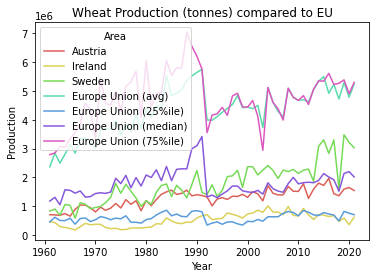

In [217]:
# Shows production change over years
ax = sns.lineplot(data=df_eu, x='Year', y='Production', hue='Area', palette='hls')
ax.set_title('Wheat Production (tonnes) compared to EU')
plt.show()

In [218]:
# Keep Ireland, Austria, and Sweden for more comparison
df_comp = df[df['Area'].isin(['Ireland', 'Austria', 'Sweden'])].reset_index(drop=True)
# Add column for Porduction per Population
df_comp['Production/Population'] = df_comp['Production'] / df_comp['Population']

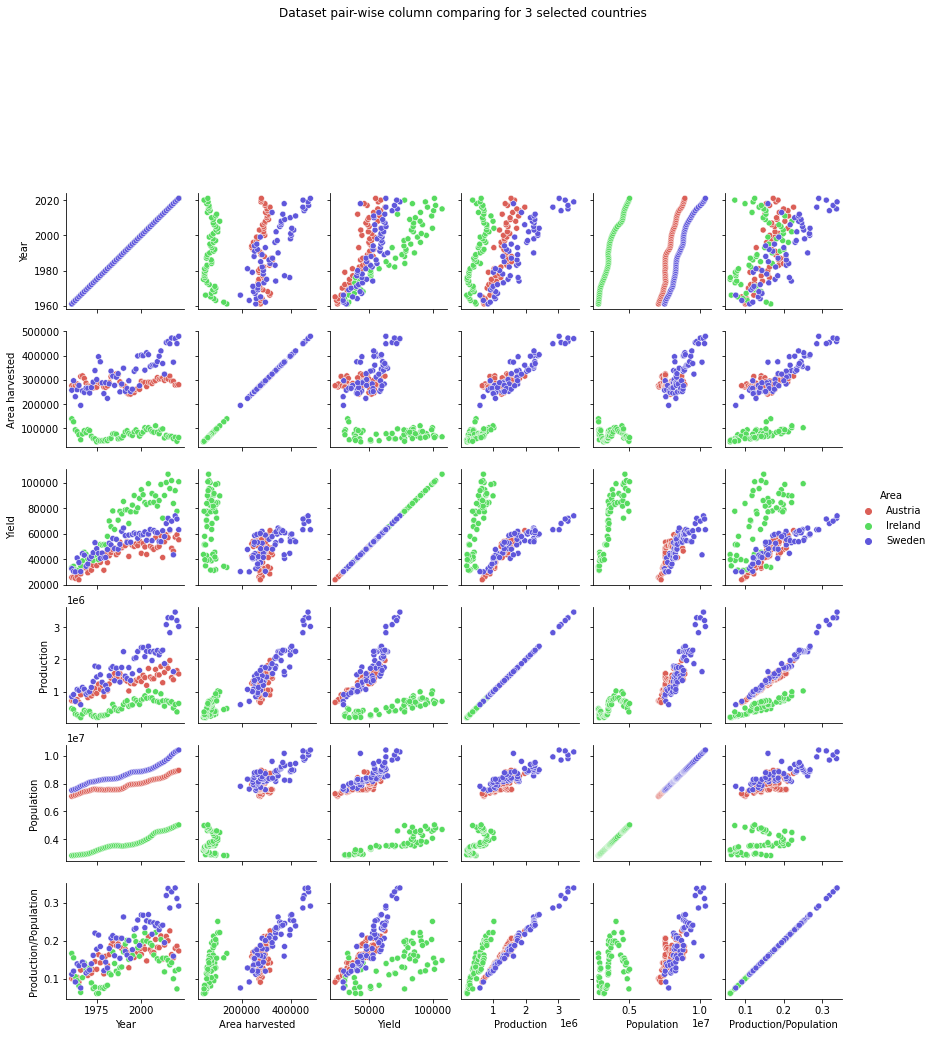

In [219]:
# Pair-wise comparison for each column
g = sns.pairplot(df_comp, size=2, hue='Area', palette='hls', diag_kind=None)
g.fig.suptitle("Dataset pair-wise column comparing for 3 selected countries", y=1.2)
plt.show()

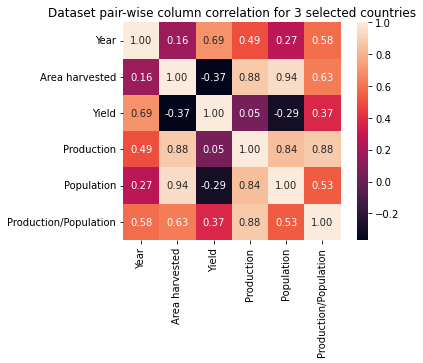

In [220]:
# Correlation of columns
# This shows when area harvested increased, yield decrease
# So, production is not increasing as much as area harvested increased
ax = sns.heatmap(df_comp.corr(), cbar=True, annot=True, square=True, fmt='.2f')
ax.set_title("Dataset pair-wise column correlation for 3 selected countries")
plt.show()

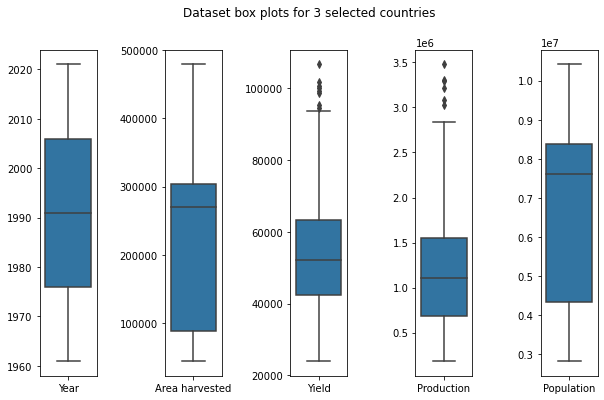

In [221]:
boxplot_columns = ['Year', 'Area harvested', 'Yield', 'Production', 'Population']
fig, ax = plt.subplots(1, len(boxplot_columns), figsize=(10, 6))
fig.suptitle("Dataset box plots for 3 selected countries")
plt.subplots_adjust(wspace=1.2)
for i in range(len(boxplot_columns)):
  sns.boxplot(data=df_comp[[boxplot_columns[i]]], ax=ax[i])
plt.show()

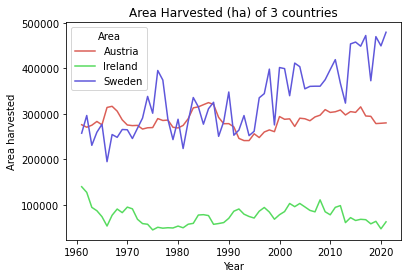

In [222]:
# Shows Harvested Area change over years of 3 target countries
ax = sns.lineplot(data=df_comp, x='Year', y='Area harvested', hue='Area', palette='hls')
ax.set_title('Area Harvested (ha) of 3 countries')
plt.show()

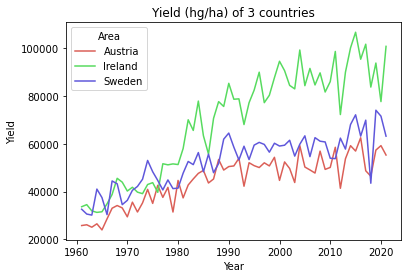

In [223]:
# Shows Yield change over years of 3 target countries
ax = sns.lineplot(data=df_comp, x='Year', y='Yield', hue='Area', palette='hls')
ax.set_title('Yield (hg/ha) of 3 countries')
plt.show()

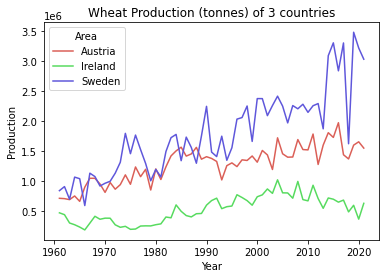

In [224]:
# Shows Production change over years of 3 target countries
ax = sns.lineplot(data=df_comp, x='Year', y='Production', hue='Area', palette='hls')
ax.set_title('Wheat Production (tonnes) of 3 countries')
plt.show()

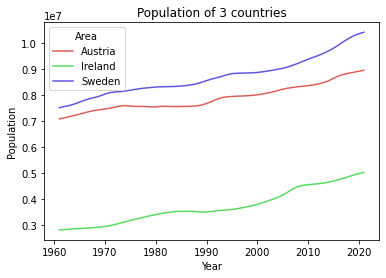

In [225]:
# Shows Population change over years of 3 target countries
ax = sns.lineplot(data=df_comp, x='Year', y='Population', hue='Area', palette='hls')
ax.set_title('Population of 3 countries')
plt.show()

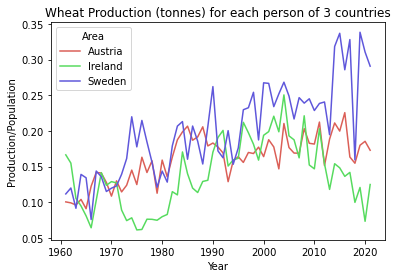

In [226]:
# Shows Population change over years of 3 target countries
ax = sns.lineplot(data=df_comp, x='Year', y='Production/Population', hue='Area', palette='hls')
ax.set_title('Wheat Production (tonnes) for each person of 3 countries')
plt.show()

### 1.3 Dashboard

In [227]:
## DASHBOARD 

In [228]:
# http://localhost:64158
        

### 1.4 Data on Europe Map

In [229]:
# function to get longitude and latitude data from country name
geolocator = Nominatim(user_agent="Europe")

def geolocate(country):
    try:
        # Geolocate the center of the country
        loc = geolocator.geocode(country)
        # And return latitude and longitude
        return (loc.latitude, loc.longitude)
    except:
        # Return missing value
        return np.nan

In [230]:
# Get longitude and latitude of each country
lati = []
longi = []
found = {}
for country in df['Area']:
  if country.startswith('Europe Union'):
    lat, long = np.nan, np.nan
  elif country in found:
    lat, long = found[country]
  else:
    location = geolocate(country)
    if location != None:
      lat, long = location
    else:
      lat, long = np.nan, np.nan
    found[country] = location
  lati.append(lat)
  longi.append(long)

In [231]:
df_loc = df.copy()
df_loc['Longitude'] = longi
df_loc['Latitude'] = lati
df_loc = df_loc.dropna()

df_loc.sample(5)

,Area,Year,Area harvested,Yield,Production,Population,Longitude,Latitude
304,Denmark,2001,634040.0,73559.0,4663938.0,5358783.0,10.333328,55.670249
511,Germany,1995,2578793.0,68882.0,17763312.0,81678051.0,10.447831,51.163818
378,Finland,1984,154000.0,31058.0,478300.0,4881803.0,25.920916,63.246778
1166,Romania,2019,2168370.0,47488.0,10297110.0,19371648.0,24.685923,45.985213
857,Luxembourg,2015,14494.0,62825.0,91058.0,569604.0,6.129675,49.815868


In [232]:
# create geographic plot for production
fig = px.scatter_geo(df_loc,  lat="Latitude", lon="Longitude", hover_name="Area",
                     size="Production", projection="natural earth", color="Area",
                     title='Average wheat production in Europe since 1961<br>(Mean production)',
                 width=800, height=800)
                     
fig.update_layout(geo_scope='europe')
fig.show()

In [177]:
# create geographic plot for population
fig = px.scatter_geo(df_loc,  lat="Latitude", lon="Longitude", hover_name="Area",
                     size="Population", projection="natural earth", color="Area",
                     title='Average population in Europe since 1961<br>(Mean population)',
                 width=800, height=800)
                     
fig.update_layout(geo_scope='europe')
fig.show()

In [178]:
# create geographic plot of Ireland, Austria and Sweden for production
df_loc_3cnt = df_loc[df_loc['Area'].isin(['Ireland', 'Austria', 'Sweden'])].reset_index(drop=True)
fig = px.scatter_geo(df_loc_3cnt,  lat="Latitude", lon="Longitude", hover_name="Area",
                     size="Production", projection="natural earth", color="Area",
                     title='Average wheat production in Ireland, Austria and Sweden since 1961<br>(Mean production)',
                 width=800, height=800)
                     
fig.update_layout(geo_scope='europe')
fig.show()

## 2. Data Statistics

In [168]:
# Statistics for select 3 countries Production
production_ie = df_comp[df_comp['Area'] == 'Ireland']['Production']
production_au = df_comp[df_comp['Area'] == 'Austria']['Production']
production_sw = df_comp[df_comp['Area'] == 'Sweden']['Production']

prod_avg_ie = production_ie.mean()
prod_avg_au = production_au.mean()
prod_avg_sw = production_sw.mean()
prod_avg_all = df_comp['Production'].mean()

print('Average Wheat Production (tonnes) of Ireland since 1961:', prod_avg_ie)
print('Average Wheat Production (tonnes) of Austria since 1961:', prod_avg_au)
print('Average Wheat Production (tonnes) of Sweden since 1961:', prod_avg_sw)
print('Average Wheat Production (tonnes) of 3 selected countries since 1961:', prod_avg_all)

Average Wheat Production (tonnes) of Ireland since 1961: 526412.7704918033
Average Wheat Production (tonnes) of Austria since 1961: 1280378.4814754096
Average Wheat Production (tonnes) of Sweden since 1961: 1787428.524590164
Average Wheat Production (tonnes) of 3 selected countries since 1961: 1198073.258852459


### 2.1 Confidence Interval

In [169]:
# Confidence interval for the Ireland Production
lower_limit_ie, upper_limit_ie = t.interval(
    alpha=0.95, df=len(production_ie), loc=production_ie.mean(),
    scale=production_ie.std()/math.sqrt(len(production_ie)))

print('======== Ireland ========')
print('Average of Production:', production_ie.mean())
print('Standart Deviation of Production:', production_ie.std())
print('Lower 95% Confidence Interval limit:', lower_limit_ie)
print('Upper 95% Confidence Interval limit:', upper_limit_ie)

======== Ireland ========
Average of Production: 526412.7704918033
Standart Deviation of Production: 218383.00705766105
Lower 95% Confidence Interval limit: 470501.1377779933
Upper 95% Confidence Interval limit: 582324.4032056134


In [170]:
# Confidence interval for the Austria Production
lower_limit_ie, upper_limit_ie = t.interval(
    alpha=0.95, df=len(production_au), loc=production_au.mean(),
    scale=production_au.std()/math.sqrt(len(production_au)))

print('======== Austria ========')
print('Average of Production:', production_au.mean())
print('Standart Deviation of Production:', production_au.std())
print('Lower 95% Confidence Interval limit:', lower_limit_ie)
print('Upper 95% Confidence Interval limit:', upper_limit_ie)

======== Austria ========
Average of Production: 1280378.4814754096
Standart Deviation of Production: 309828.59934353665
Lower 95% Confidence Interval limit: 1201054.4393526812
Upper 95% Confidence Interval limit: 1359702.523598138


In [171]:
# Confidence interval for the Sweden Production
lower_limit_ie, upper_limit_ie = t.interval(
    alpha=0.95, df=len(production_sw), loc=production_sw.mean(),
    scale=production_sw.std()/math.sqrt(len(production_sw)))

print('======== Sweden ========')
print('Average of Production:', production_sw.mean())
print('Standart Deviation of Production:', production_sw.std())
print('Lower 95% Confidence Interval limit:', lower_limit_ie)
print('Upper 95% Confidence Interval limit:', upper_limit_ie)

======== Sweden ========
Average of Production: 1787428.524590164
Standart Deviation of Production: 698742.0714513476
Lower 95% Confidence Interval limit: 1608532.6911320267
Upper 95% Confidence Interval limit: 1966324.3580483012


### 2.2. One-Sample T-Test

In [172]:
# One-Sample T-Test for Ireland wheat production with its average to confirm the test is working well
print('For Ireland, testing null hypothesis with mean production Ireland:')
tstatistics, pvalue = ttest_1samp(production_ie, popmean=prod_avg_ie)
print('Ireland average production:', prod_avg_ie)
print('tstatistics:', tstatistics)
print('pvalue:', pvalue)
if pvalue < 0.05:  # Using 95% confidence level
  print('Null hypothesis is rejected for Ireland production compared to Ireland average')
else:
  print('Null hypothesis cant be rejected for Ireland production compared to Ireland average')

For Ireland, testing null hypothesis with mean production Ireland:
Ireland average production: 526412.7704918033
tstatistics: 0.0
pvalue: 1.0
Null hypothesis cant be rejected for Ireland production compared to Ireland average


In [173]:
# One-Sample T-Test for Ireland wheat production with 95% confidence level
print('For Ireland, testing null hypothesis with mean production of 3 countries:')
tstatistics, pvalue = ttest_1samp(production_ie, popmean=prod_avg_all)
print('Ireland average production:', prod_avg_ie)
print('3 countries average production:', prod_avg_all)
print('tstatistics:', tstatistics)
print('pvalue:', pvalue)
if pvalue < 0.05:  # Using 95% confidence level
  print('Null hypothesis is rejected for Ireland production compared to 3 countries average')
else:
  print('Null hypothesis cant be rejected for Ireland production compared to 3 countries average')

For Ireland, testing null hypothesis with mean production of 3 countries:
Ireland average production: 526412.7704918033
3 countries average production: 1198073.258852459
tstatistics: -24.021265125967535
pvalue: 1.7853852651601438e-32
Null hypothesis is rejected for Ireland production compared to 3 countries average


In [174]:
# One-Sample T-Test for Sweden wheat production with 95% confidence level
print('For Sweden, testing null hypothesis with mean production of 3 countries:')
tstatistics, pvalue = ttest_1samp(production_sw, popmean=prod_avg_all)
print('Sweden average production:', prod_avg_sw)
print('3 countries average production:', prod_avg_all)
print('tstatistics:', tstatistics)
print('pvalue:', pvalue)
if pvalue < 0.05:  # Using 95% confidence level
  print('Null hypothesis is rejected for Sweden production compared to 3 countries average')
else:
  print('Null hypothesis cant be rejected for Sweden production compared to 3 countries average')

For Sweden, testing null hypothesis with mean production of 3 countries:
Sweden average production: 1787428.524590164
3 countries average production: 1198073.258852459
tstatistics: 6.587569235184218
pvalue: 1.2583068664291155e-08
Null hypothesis is rejected for Sweden production compared to 3 countries average


In [175]:
# One-Sample T-Test for Austria wheat production with 95% confidence level
print('For Austria, testing null hypothesis with mean production of 3 countries:')
tstatistics, pvalue = ttest_1samp(production_au, popmean=prod_avg_all)
print('Austria average production:', prod_avg_au)
print('3 countries average production:', prod_avg_all)
print('tstatistics:', tstatistics)
print('pvalue:', pvalue)
if pvalue < 0.05:  # Using 95% confidence level
  print('Null hypothesis is rejected for Austria production compared to 3 countries average')
else:
  print('Null hypothesis cant be rejected for Austria production compared to 3 countries average')

For Austria, testing null hypothesis with mean production of 3 countries:
Austria average production: 1280378.4814754096
3 countries average production: 1198073.258852459
tstatistics: 2.074774051454061
pvalue: 0.04230451147699142
Null hypothesis is rejected for Austria production compared to 3 countries average


### 2.3. Two-Sample T-Test

In [69]:
# Two-Sample T-Test for Ireland and Sweden
print('Testing null hypothesis for Ireland and Sweden wheat production:')
tstatistics, pvalue = ttest_ind(production_ie, production_sw)
print('Ireland average production:', prod_avg_ie)
print('Sweden average production:', prod_avg_sw)
print('tstatistics:', tstatistics)
print('pvalue:', pvalue)
if pvalue < 0.05:  # Using 95% confidence level
  print('Null hypothesis is rejected, there is a significant difference between Ireland and Sweden wheat productions')
else:
  print('Null hypothesis cant be rejected, no significant difference between Ireland and Sweden wheat productions')

Testing null hypothesis for Ireland and Sweden wheat production:
Ireland average production: 526412.7704918033
Sweden average production: 1787428.524590164
tstatistics: -13.453359240100587
pvalue: 1.0163993627529193e-25
Null hypothesis is rejected, there is a significant difference between Ireland and Sweden wheat productions


In [70]:
# Two-Sample T-Test for Ireland and Austria
print('Testing null hypothesis for Ireland and Austria wheat production:')
tstatistics, pvalue = ttest_ind(production_ie, production_au)
print('Ireland average production:', prod_avg_ie)
print('Austria average production:', prod_avg_au)
print('tstatistics:', tstatistics)
print('pvalue:', pvalue)
if pvalue < 0.05:  # Using 95% confidence level
  print('Null hypothesis is rejected, there is a significant difference between Ireland and Austria wheat productions')
else:
  print('Null hypothesis cant be rejected, no significant difference between Ireland and Austria wheat productions')

Testing null hypothesis for Ireland and Austria wheat production:
Ireland average production: 526412.7704918033
Austria average production: 1280378.4814754096
tstatistics: -15.534988988525395
pvalue: 1.673192186211768e-30
Null hypothesis is rejected, there is a significant difference between Ireland and Austria wheat productions


In [71]:
# Two-Sample T-Test for Austria and Sweden
print('Testing null hypothesis for Austria and Sweden wheat production:')
tstatistics, pvalue = ttest_ind(production_au, production_sw)
print('Austria average production:', prod_avg_au)
print('Sweden average production:', prod_avg_sw)
print('tstatistics:', tstatistics)
print('pvalue:', pvalue)
if pvalue < 0.05:  # Using 95% confidence level
  print('Null hypothesis is rejected, there is a significant difference between Austria and Sweden wheat productions')
else:
  print('Null hypothesis cant be rejected, no significant difference between Austria and Sweden wheat productions')

Testing null hypothesis for Austria and Sweden wheat production:
Austria average production: 1280378.4814754096
Sweden average production: 1787428.524590164
tstatistics: -5.181103132986639
pvalue: 9.021887897239782e-07
Null hypothesis is rejected, there is a significant difference between Austria and Sweden wheat productions


### 2.4. Chi-Square Test

In [72]:
# Chi-square test for Ireland and Sweden
print('Testing null hypothesis for Ireland and Sweden wheat production:')
print('Ireland average production:', prod_avg_ie)
print('Sweden average production:', prod_avg_sw)
try:
  chisq, pvalue = chisquare(production_ie, production_sw)
  print('chisq:', chisq)
  print('pvalue:', pvalue)
except Exception as err:
  print('Frequencies of 2 countries are not relative, and above tolerance of chi-square testing')

Testing null hypothesis for Ireland and Sweden wheat production:
Ireland average production: 526412.7704918033
Sweden average production: 1787428.524590164
Frequencies of 2 countries are not relative, and above tolerance of chi-square testing


In [73]:
# Chi-square test for Ireland and Austria
print('Testing null hypothesis for Ireland and Austria wheat production:')
print('Ireland average production:', prod_avg_ie)
print('Austria average production:', prod_avg_au)
try:
  chisq, pvalue = chisquare(production_ie, production_au)
  print('chisq:', chisq)
  print('pvalue:', pvalue)
except Exception as err:
  print('Frequencies of 2 countries are not relative, and above tolerance of chi-square testing')

Testing null hypothesis for Ireland and Austria wheat production:
Ireland average production: 526412.7704918033
Austria average production: 1280378.4814754096
Frequencies of 2 countries are not relative, and above tolerance of chi-square testing


In [74]:
# Chi-square test for Sweden and Austria
print('Testing null hypothesis for Sweden and Austria wheat production:')
print('Sweden average production:', prod_avg_sw)
print('Austria average production:', prod_avg_au)
try:
  chisq, pvalue = chisquare(production_sw, production_au)
  print('chisq:', chisq)
  print('pvalue:', pvalue)
except Exception as err:
  print('Frequencies of 2 countries are not relative, and above tolerance of chi-square testing')

Testing null hypothesis for Sweden and Austria wheat production:
Sweden average production: 1787428.524590164
Austria average production: 1280378.4814754096
Frequencies of 2 countries are not relative, and above tolerance of chi-square testing


In [75]:
# Chi-square test for Ireland
print('Chi-square for Ireland:')
print('Ireland average production:', prod_avg_ie)
chisq, pvalue = chisquare(production_ie)
print('chisq:', chisq)
print('pvalue:', pvalue)

Chi-square for Ireland:
Ireland average production: 526412.7704918033
chisq: 5435788.086256814
pvalue: 0.0


In [76]:
# Chi-square test for Austria
print('Chi-square for Austria:')
print('Austria average production:', prod_avg_au)
chisq, pvalue = chisquare(production_au)
print('chisq:', chisq)
print('pvalue:', pvalue)

Chi-square for Austria:
Austria average production: 1280378.4814754096
chisq: 4498377.426363584
pvalue: 0.0


In [77]:
# Chi-square test for Sweden
print('Chi-square for Sweden:')
print('Sweden average production:', prod_avg_sw)
chisq, pvalue = chisquare(production_sw)
print('chisq:', chisq)
print('pvalue:', pvalue)

Chi-square for Sweden:
Sweden average production: 1787428.524590164
chisq: 16389147.057885336
pvalue: 0.0


### 2.5. Two-Sample  Cramér-von Mises test

In [78]:
# Cramér-von Mises test for Ireland and Austria
print('Testing null hypothesis for Ireland and Austria wheat production:')
print('Ireland average production:', prod_avg_ie)
print('Austria average production:', prod_avg_au)
cramervonmises_result = cramervonmises_2samp(production_ie, production_au)
print('statistics:', cramervonmises_result.statistic)
print('pvalue:', cramervonmises_result.pvalue)
if cramervonmises_result.pvalue < 0.05:  # Using 95% confidence level
  print('Null hypothesis is rejected, there is a significant difference between Ireland and Austria wheat productions')
else:
  print('Null hypothesis cant be rejected, no significant difference between Ireland and Austria wheat productions')

Testing null hypothesis for Ireland and Austria wheat production:
Ireland average production: 526412.7704918033
Austria average production: 1280378.4814754096
statistics: 8.803077129803814
pvalue: 1.9003265627759447e-10
Null hypothesis is rejected, there is a significant difference between Ireland and Austria wheat productions


In [79]:
# Cramér-von Mises test for Ireland and Sweden
print('Testing null hypothesis for Ireland and Sweden wheat production:')
print('Ireland average production:', prod_avg_ie)
print('Sweden average production:', prod_avg_sw)
cramervonmises_result = cramervonmises_2samp(production_ie, production_sw)
print('statistics:', cramervonmises_result.statistic)
print('pvalue:', cramervonmises_result.pvalue)
if cramervonmises_result.pvalue < 0.05:  # Using 95% confidence level
  print('Null hypothesis is rejected, there is a significant difference between Ireland and Sweden wheat productions')
else:
  print('Null hypothesis cant be rejected, no significant difference between Ireland and Sweden wheat productions')

Testing null hypothesis for Ireland and Sweden wheat production:
Ireland average production: 526412.7704918033
Sweden average production: 1787428.524590164
statistics: 9.397272238645524
pvalue: 6.485376680132049e-10
Null hypothesis is rejected, there is a significant difference between Ireland and Sweden wheat productions


In [80]:
# Cramér-von Mises test for Austria and Sweden
print('Testing null hypothesis for Austria and Sweden wheat production:')
print('Austria average production:', prod_avg_au)
print('Sweden average production:', prod_avg_sw)
cramervonmises_result = cramervonmises_2samp(production_au, production_sw)
print('statistics:', cramervonmises_result.statistic)
print('pvalue:', cramervonmises_result.pvalue)
if cramervonmises_result.pvalue < 0.05:  # Using 95% confidence level
  print('Null hypothesis is rejected, there is a significant difference between Austria and Sweden wheat productions')
else:
  print('Null hypothesis cant be rejected, no significant difference between Austria and Sweden wheat productions')

Testing null hypothesis for Austria and Sweden wheat production:
Austria average production: 1280378.4814754096
Sweden average production: 1787428.524590164
statistics: 2.1115963450685307
pvalue: 6.933502145312076e-06
Null hypothesis is rejected, there is a significant difference between Austria and Sweden wheat productions


### 2.6. Two-Sample Kolmogorov-Smirnov test

In [81]:
# Kolmogorov-Smirnov test for Ireland and Austria
print('Testing null hypothesis for Ireland and Austria wheat production:')
print('Ireland average production:', prod_avg_ie)
print('Austria average production:', prod_avg_au)
ks_statistic, pvalue = ks_2samp(production_ie, production_au)
print('ks statistics:', ks_statistic)
print('pvalue:', pvalue)
if pvalue < 0.05:  # Using 95% confidence level
  print('Null hypothesis is rejected, there is a significant difference between Ireland and Austria wheat productions')
else:
  print('Null hypothesis cant be rejected, no significant difference between Ireland and Austria wheat productions')

Testing null hypothesis for Ireland and Austria wheat production:
Ireland average production: 526412.7704918033
Austria average production: 1280378.4814754096
ks statistics: 0.8524590163934426
pvalue: 6.364132921793145e-23
Null hypothesis is rejected, there is a significant difference between Ireland and Austria wheat productions


In [82]:
# Kolmogorov-Smirnov test for Ireland and Sweden
print('Testing null hypothesis for Ireland and Sweden wheat production:')
print('Ireland average production:', prod_avg_ie)
print('Sweden average production:', prod_avg_sw)
ks_statistic, pvalue = ks_2samp(production_ie, production_sw)
print('ks statistics:', ks_statistic)
print('pvalue:', pvalue)
if pvalue < 0.05:  # Using 95% confidence level
  print('Null hypothesis is rejected, there is a significant difference between Ireland and Sweden wheat productions')
else:
  print('Null hypothesis cant be rejected, no significant difference between Ireland and Sweden wheat productions')

Testing null hypothesis for Ireland and Sweden wheat production:
Ireland average production: 526412.7704918033
Sweden average production: 1787428.524590164
ks statistics: 0.9016393442622951
pvalue: 2.1091579161628038e-26
Null hypothesis is rejected, there is a significant difference between Ireland and Sweden wheat productions


In [83]:
# Kolmogorov-Smirnov test for Austria and Sweden
print('Testing null hypothesis for Austria and Sweden wheat production:')
print('Austria average production:', prod_avg_au)
print('Sweden average production:', prod_avg_sw)
ks_statistic, pvalue = ks_2samp(production_au, production_sw)
print('ks statistics:', ks_statistic)
print('pvalue:', pvalue)
if pvalue < 0.05:  # Using 95% confidence level
  print('Null hypothesis is rejected, there is a significant difference between Austria and Sweden wheat productions')
else:
  print('Null hypothesis cant be rejected, no significant difference between Austria and Sweden wheat productions')

Testing null hypothesis for Austria and Sweden wheat production:
Austria average production: 1280378.4814754096
Sweden average production: 1787428.524590164
ks statistics: 0.45901639344262296
pvalue: 3.5946813374357002e-06
Null hypothesis is rejected, there is a significant difference between Austria and Sweden wheat productions


### 2.7. Mann-Whitney U rank test

In [84]:
# Mann-Whitney U test for Ireland and Austria
print('Testing null hypothesis for Ireland and Austria wheat production:')
print('Ireland average production:', prod_avg_ie)
print('Austria average production:', prod_avg_au)
statistic, pvalue = mannwhitneyu(production_ie, production_au)
print('statistics:', statistic)
print('pvalue:', pvalue)
if pvalue < 0.05:  # Using 95% confidence level
  print('Null hypothesis is rejected, there is a significant difference between Ireland and Austria wheat productions')
else:
  print('Null hypothesis cant be rejected, no significant difference between Ireland and Austria wheat productions')

Testing null hypothesis for Ireland and Austria wheat production:
Ireland average production: 526412.7704918033
Austria average production: 1280378.4814754096
statistics: 100.0
pvalue: 2.0234317056347564e-19
Null hypothesis is rejected, there is a significant difference between Ireland and Austria wheat productions


In [85]:
# Mann-Whitney U test for Ireland and Sweden
print('Testing null hypothesis for Ireland and Sweden wheat production:')
print('Ireland average production:', prod_avg_ie)
print('Sweden average production:', prod_avg_sw)
statistic, pvalue = mannwhitneyu(production_ie, production_sw)
print('statistics:', statistic)
print('pvalue:', pvalue)
if pvalue < 0.05:  # Using 95% confidence level
  print('Null hypothesis is rejected, there is a significant difference between Ireland and Sweden wheat productions')
else:
  print('Null hypothesis cant be rejected, no significant difference between Ireland and Sweden wheat productions')

Testing null hypothesis for Ireland and Sweden wheat production:
Ireland average production: 526412.7704918033
Sweden average production: 1787428.524590164
statistics: 57.0
pvalue: 2.6519497765395777e-20
Null hypothesis is rejected, there is a significant difference between Ireland and Sweden wheat productions


In [86]:
# Mann-Whitney U test for Austria and Sweden
print('Testing null hypothesis for Austria and Sweden wheat production:')
print('Austria average production:', prod_avg_au)
print('Sweden average production:', prod_avg_sw)
statistic, pvalue = mannwhitneyu(production_au, production_sw)
print('statistics:', statistic)
print('pvalue:', pvalue)
if pvalue < 0.05:  # Using 95% confidence level
  print('Null hypothesis is rejected, there is a significant difference between Austria and Sweden wheat productions')
else:
  print('Null hypothesis cant be rejected, no significant difference between Austria and Sweden wheat productions')

Testing null hypothesis for Austria and Sweden wheat production:
Austria average production: 1280378.4814754096
Sweden average production: 1787428.524590164
statistics: 1030.0
pvalue: 2.1379484964367695e-05
Null hypothesis is rejected, there is a significant difference between Austria and Sweden wheat productions


### 2.8. Kruskal-Wallis H-test

In [87]:
# Kruskal-Wallis H-test for Ireland and Austria
print('Testing null hypothesis for Ireland and Austria wheat production:')
print('Ireland average production:', prod_avg_ie)
print('Austria average production:', prod_avg_au)
statistic, pvalue = kruskal(production_ie, production_au)
print('statistics:', statistic)
print('pvalue:', pvalue)
if pvalue < 0.05:  # Using 95% confidence level
  print('Null hypothesis is rejected, there is a significant difference between Ireland and Austria wheat productions')
else:
  print('Null hypothesis cant be rejected, no significant difference between Ireland and Austria wheat productions')

Testing null hypothesis for Ireland and Austria wheat production:
Ireland average production: 526412.7704918033
Austria average production: 1280378.4814754096
statistics: 81.26219020588485
pvalue: 1.976725061173741e-19
Null hypothesis is rejected, there is a significant difference between Ireland and Austria wheat productions


In [88]:
# Kruskal-Wallis H-test for Ireland and Sweden
print('Testing null hypothesis for Ireland and Sweden wheat production:')
print('Ireland average production:', prod_avg_ie)
print('Sweden average production:', prod_avg_sw)
statistic, pvalue = kruskal(production_ie, production_sw)
print('statistics:', statistic)
print('pvalue:', pvalue)
if pvalue < 0.05:  # Using 95% confidence level
  print('Null hypothesis is rejected, there is a significant difference between Ireland and Sweden wheat productions')
else:
  print('Null hypothesis cant be rejected, no significant difference between Ireland and Sweden wheat productions')

Testing null hypothesis for Ireland and Sweden wheat production:
Ireland average production: 526412.7704918033
Sweden average production: 1787428.524590164
statistics: 85.28030754911151
pvalue: 2.5892914982995952e-20
Null hypothesis is rejected, there is a significant difference between Ireland and Sweden wheat productions


In [89]:
# Kruskal-Wallis H-test for Austria and Sweden
print('Testing null hypothesis for Austria and Sweden wheat production:')
print('Austria average production:', prod_avg_au)
print('Sweden average production:', prod_avg_sw)
statistic, pvalue = kruskal(production_au, production_sw)
print('statistics:', statistic)
print('pvalue:', pvalue)
if pvalue < 0.05:  # Using 95% confidence level
  print('Null hypothesis is rejected, there is a significant difference between Austria and Sweden wheat productions')
else:
  print('Null hypothesis cant be rejected, no significant difference between Austria and Sweden wheat productions')

Testing null hypothesis for Austria and Sweden wheat production:
Austria average production: 1280378.4814754096
Sweden average production: 1787428.524590164
statistics: 18.084051625251504
pvalue: 2.1136442460305135e-05
Null hypothesis is rejected, there is a significant difference between Austria and Sweden wheat productions


## 3. Machine Learning

In [90]:
# Looking at Dataset to determine features and target
df.sample(5)

,Area,Year,Area harvested,Yield,Production,Population
1042,Poland,2017,2391853.0,48773.0,11665702.0,37974826.0
244,Czechia,2002,848830.0,45551.0,3866473.0,10196916.0
1195,Slovenia,2018,27820.0,43817.0,121900.0,2073894.0
56,Europe Union (median),2017,455055.5,50312.5,1920760.5,9292766.0
1212,Spain,1974,3164400.0,14330.0,4534600.0,35373335.0


In [91]:
# Decided to Predict production of Ireland
df_ml = df[df['Area']=='Ireland'].drop('Area', axis=1)
df_ml.sample(5)

,Year,Area harvested,Yield,Production,Population
666,1967,76810.0,38797.0,298000.0,2902450.0
669,1970,94695.0,40234.0,381000.0,2957250.0
683,1984,77300.0,77878.0,602000.0,3532423.0
700,2001,84900.0,90601.0,769200.0,3866243.0
661,1962,127069.0,34548.0,439000.0,2836050.0


In [92]:
# Checking correlation of features
df_ml.corr()

,Year,Area harvested,Yield,Production,Population
Year,1.000000,-0.045566,0.921999,0.728484,0.974933
Area harvested,-0.045566,1.000000,0.022016,0.535028,-0.073945
Yield,0.921999,0.022016,1.000000,0.831038,0.850603
Production,0.728484,0.535028,0.831038,1.000000,0.641561
Population,0.974933,-0.073945,0.850603,0.641561,1.000000


In [93]:
# Splitting Production as prediction target, and others columns as features
X_all = df_ml.drop('Production', axis=1)
y_all = df_ml['Production']

In [94]:
# Since all features have different unit types, using a scaler before training
scaler = StandardScaler()
X_all = pd.DataFrame(scaler.fit_transform(X_all), index=X_all.index, columns=X_all.columns)
X_all.sample(5)

,Year,Area harvested,Yield,Population
667,-1.306312,0.752345,-1.062397,-1.241412
709,1.079127,0.103445,0.744957,1.273852
683,-0.397573,0.077877,0.381404,-0.297965
690,0.000000,0.507410,0.415717,-0.295193
712,1.249516,-0.776073,0.922243,1.371216


In [95]:
# Removing last 5 years to predict after training a tuned model
year_selection = [2017, 2018, 2019, 2020, 2021]

X_last5years = X_all[df_ml['Year'].isin(year_selection)]
y_last5years = y_all[df_ml['Year'].isin(year_selection)]

X = X_all[~df_ml['Year'].isin(year_selection)]
y = y_all[~df_ml['Year'].isin(year_selection)]

X.sample(5)

,Year,Area harvested,Yield,Population
685,-0.283981,0.016516,-0.608772,-0.286850
672,-1.022331,-0.884581,-1.349237,-0.980802
687,-0.170389,-0.878343,0.370994,-0.309395
702,0.681554,1.018757,0.609267,0.411828
680,-0.567962,-1.353896,-0.506189,-0.419434


In [96]:
# Using 10-Fold (90% to train, 10% to validate)
cv = KFold(n_splits=10, random_state=1, shuffle=True)

# Using Mean Squared Error for Production
# Negative is needed to show higher is better
PRODUCTION_SCORER = 'neg_mean_squared_error'

# Creating a common function for CV scoring to be used later
# Returns average MSE for for cv results 
def cv_scoring(model, X, y):
  scores = cross_val_score(model, X, y, scoring=PRODUCTION_SCORER, cv=cv)
  return -scores.mean()

In [97]:
# Splitting 10% of the data as test for grid paramtered tuning
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1)
print(df_ml.shape, X.shape, y.shape)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(61, 5) (56, 4) (56,)
(50, 4) (6, 4) (50,) (6,)


In [98]:
# Grid Search takes long time, creating a flag to skip tuning and using best params found before
skip_linear = {'fit_intercept': True, 'positive': False}
skip_rfr = {'max_depth': 8, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 320, 'random_state': 1}
skip_gbr = {'alpha': 0.1, 'criterion': 'squared_error', 'learning_rate': 0.1, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 384, 'random_state': 1, 'subsample': 0.5}

### 3.1 Linear Regression tuning

In [99]:
# Testing non-tuned Linear Regression
linear_model = LinearRegression()
linear_error = cv_scoring(linear_model, X, y)
print('Linear Regression error (million tonnes):', linear_error/1e6)

Linear Regression error (million tonnes): 2166.359233313741


In [100]:
# Grid parmeter tuning for Linear regression model
linear_param_grid = {
    'fit_intercept': [True, False],
    'positive': [True, False],
}
if skip_linear is None:
  linear_tuning = GridSearchCV(LinearRegression(), linear_param_grid, scoring=PRODUCTION_SCORER, cv=cv, verbose=1)
  linear_tuning.fit(X, y)
  linear_best_params = linear_tuning.best_params_
  print('Linear Regression mean squared error (million tonnes):', -linear_tuning.best_score_/1e6)
  print('Best parameters:')
  print(print(linear_best_params))
else:
  print('Skip grid search for Linear Regression, using best params below:')
  print(skip_linear)
  linear_best_params = skip_linear

Skip grid search for Linear Regression, using best params below:
{'fit_intercept': True, 'positive': False}


### 3.2 Random Forest Regression tuning

In [101]:
# Testing non-tuned Random Forest Regression
rfr_model = RandomForestRegressor()
rfr_error = cv_scoring(rfr_model, X, y)
print('Random Forest mean squared error (million tonnes):', rfr_error/1e6)

Random Forest mean squared error (million tonnes): 3166.4511768804


In [102]:
# Grid parmeter tuning for Random Forest regression model
rfr_param_grid = {
    'n_estimators': [256, 288, 320, 352, 384],
    'min_samples_split': [1, 2, 3],
    'min_samples_leaf': [1, 2, 3],
    'random_state': [1],
    'max_features': [None],
    'max_depth': [None, 4, 6, 8, 10],
}
if skip_rfr is None:
  rfr_tuning = GridSearchCV(RandomForestRegressor(), rfr_param_grid, scoring=PRODUCTION_SCORER, cv=cv, verbose=1, n_jobs=-1)
  rfr_tuning.fit(X, y)
  rfr_best_params = rfr_tuning.best_params_
  print('Random Forest Regression mean squared error (million tonnes):', -rfr_tuning.best_score_/1e6)
  print('Best parameters:')
  print(print(rfr_best_params))
else:
  print('Skip grid search for Random Forest Regression, using best params below:')
  print(skip_rfr)
  rfr_best_params = skip_rfr

Skip grid search for Random Forest Regression, using best params below:
{'max_depth': 8, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 320, 'random_state': 1}


### 3.3 Gradient Boosting Regression tuning

In [103]:
# Testing non-tuned Gradient Boosting Regression
gbr_model = GradientBoostingRegressor()
gbr_error = cv_scoring(gbr_model, X, y)
print('Gradient Boosting mean squared error (million tonnes):', gbr_error/1e6)

Gradient Boosting mean squared error (million tonnes): 2380.6392869074984


In [104]:
# Grid parmeter tuning for Gradint Boosting regression model
gbr_param_grid = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.5],
    'n_estimators': [128, 192, 256, 320, 384],
    'subsample': [0.5, 1.0],
    'criterion': ['friedman_mse', 'squared_error'],
    'min_samples_split': [1, 2, 3],
    'min_samples_leaf': [1, 2, 3],
    'alpha': [0.1, 0.5, 0.9],
    'random_state': [1],
}
if skip_gbr is None:
  gbr_tuning = GridSearchCV(GradientBoostingRegressor(), gbr_param_grid, scoring=PRODUCTION_SCORER, cv=cv, verbose=1, n_jobs=-1)
  gbr_tuning.fit(X, y)
  gbr_best_params = gbr_tuning.best_params_
  print('Gradint Boosting Regression mean squared error (million tonnes):', -gbr_tuning.best_score_/1e6)
  print('Best parameters:')
  print(print(gbr_best_params))
else:
  print('Skip grid search for Gradint Boosting Regression, using best params below:')
  print(skip_gbr)
  gbr_best_params = skip_gbr

Skip grid search for Gradint Boosting Regression, using best params below:
{'alpha': 0.1, 'criterion': 'squared_error', 'learning_rate': 0.1, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 384, 'random_state': 1, 'subsample': 0.5}


### 3.4 Compare Models

In [105]:
# Comparing 3 models with tuned and not tuned paramters
models_comp = [
    (LinearRegression(), 'Linear Regression not-tuned'),
    (RandomForestRegressor(), 'Random Forest not-tuned'),
    (GradientBoostingRegressor(), 'Gradient Boosting not-tuned'),
    (LinearRegression(**linear_best_params), 'Linear Regression tuned'),
    (RandomForestRegressor(**rfr_best_params), 'Random Forest tuned'),
    (GradientBoostingRegressor(**gbr_best_params), 'Gradient Boosting tuned'),
]
results = []
for model, name in models_comp:
  cv_result = cv_scoring(model, X, y)
  results.append((cv_result, name))

results.sort()
print('From best to least score:')
for mse, model in results:
  print(model, 'mean squared error (million tonnes):', mse/1e6)

From best to least score:
Gradient Boosting tuned mean squared error (million tonnes): 1104.764037519785
Linear Regression not-tuned mean squared error (million tonnes): 2166.359233313741
Linear Regression tuned mean squared error (million tonnes): 2166.359233313741
Gradient Boosting not-tuned mean squared error (million tonnes): 2339.8018088986237
Random Forest tuned mean squared error (million tonnes): 3001.554591259632
Random Forest not-tuned mean squared error (million tonnes): 3084.0314875365334


In [106]:
# According to comparison above, Gradient Boosting had least error
best_model = GradientBoostingRegressor(**gbr_best_params)
best_model.fit(X, y)
pred = best_model.predict(X)

# Scores of best model
print('For training dataset:')
print('R2 score', r2_score(y, pred))
print('MAE score', mean_absolute_error(y, pred))
print('MSE score', mean_squared_error(y, pred))

For training dataset:
R2 score 0.9999049310081728
MAE score 1236.7135590596642
MSE score 4743676.410416852


### 3.5 Visualising Predictions

In [107]:
# Predicting last 5 years which wasn't used in training
pred_last5years = best_model.predict(X_last5years)

pred_results = df_ml[df_ml['Year'].isin(year_selection)].copy()
pred_results['Predicted Production'] = pred_last5years.astype('int64')
pred_results['Real Production'] = y_last5years

pred_results

,Year,Area harvested,Yield,Production,Population,Predicted Production,Real Production
716,2017,67047.0,101672.0,681679.0,4807388.0,697298,681679.0
717,2018,57980.0,83732.0,485480.0,4867316.0,521338,485480.0
718,2019,63480.0,93787.0,595360.0,4934340.0,632415,595360.0
719,2020,46990.0,77659.0,364920.0,4985382.0,515338,364920.0
720,2021,62330.0,100767.0,628080.0,5033165.0,670487,628080.0


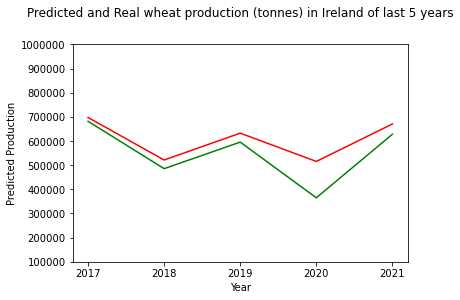

In [108]:
# Shows predicting next year is more possible than predicting 5 years later in advance
ax = sns.lineplot(data=pred_results, x='Year', y='Predicted Production', color='red')
ax = sns.lineplot(data=pred_results, x='Year', y='Real Production', color='green', ax=ax)
ax.set_title('Predicted and Real wheat production (tonnes) in Ireland of last 5 years', y=1.1)
ax.yaxis.set_major_formatter(tck.FuncFormatter(lambda y, _: f'{y:.0f}'))
ax.xaxis.set_major_locator(plt.MaxNLocator(5))
plt.ylim([1e5, 1e6])
plt.show()

In [109]:
# Predicting last 5 years which wasn't used in training
pred_all = best_model.predict(X_all)

pred_results_all = df_ml.copy()
pred_results_all['Predicted Production'] = pred_all.astype('int64')
pred_results_all['Real Production'] = y_all

pred_results_all.sample(5)

,Year,Area harvested,Yield,Production,Population,Predicted Production,Real Production
699,2000,78000.0,94538.0,737400.0,3805174.0,737597,737400.0
682,1983,59000.0,65593.0,387000.0,3510600.0,388165,387000.0
697,1998,83800.0,80310.0,673000.0,3712696.0,673352,673000.0
667,1968,90490.0,45563.0,412300.0,2915550.0,412865,412300.0
683,1984,77300.0,77878.0,602000.0,3532423.0,601865,602000.0


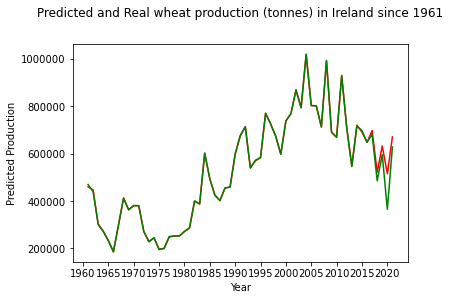

In [110]:
ax = sns.lineplot(data=pred_results_all, x='Year', y='Predicted Production', color='red')
ax = sns.lineplot(data=pred_results_all, x='Year', y='Real Production', color='green', ax=ax)
ax.set_title('Predicted and Real wheat production (tonnes) in Ireland since 1961', y=1.1)
ax.yaxis.set_major_formatter(tck.FuncFormatter(lambda y, _: f'{y:.0f}'))
ax.xaxis.set_major_locator(plt.MaxNLocator(15))
plt.show()

In [111]:
# Correlation of Prediction (99.5%)
pred_results_all[['Predicted Production', 'Real Production']].corr()

,Predicted Production,Real Production
Predicted Production,1.000000,0.995402
Real Production,0.995402,1.000000
